In [3]:
# Importing libraries
from copy import deepcopy
import random


# Math Libraries
import random
import math
import numpy as np

# Data Processing
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt  
import seaborn as sns 
from sympy import var, plot_implicit

# ML
from sklearn.linear_model import LogisticRegression # Importing Logistic Model
from sklearn.model_selection import train_test_split # Train Test Split
from sklearn.preprocessing import MinMaxScaler # Data normalizer Min Max Scale
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error # Calculate the accuracy
from sklearn.svm import LinearSVC
# Loading Bar
from time import sleep
from tqdm import tqdm

# Convex Hull
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
from numpy.linalg import det
from scipy.stats import dirichlet
from scipy.spatial.distance import euclidean
from scipy import stats as st
from scipy.optimize import fmin_tnc

# Supress warnings
import warnings; warnings.simplefilter('ignore')

In [4]:
def Adult_Data_Clean(df: pd.DataFrame) -> pd.DataFrame:
  # Changing collumn names for convenience
  df.rename(columns={'capital-gain': 'gain', 'capital-loss': 'loss', 'native-country': 'country',
                    'hours-per-week': 'hours','marital-status': 'marital'}, inplace=True)
  
  # Finding not known data
  df['country'] = df['country'].replace('?',np.nan)
  df['workclass'] = df['workclass'].replace('?',np.nan)
  df['occupation'] = df['occupation'].replace('?',np.nan)
  
  # Dropping not known data
  df.dropna(how='any',inplace=True)

  # Normalizing numerical features
  numerical = ['age', 'fnlwgt', 'educational-num', 'gain', 'loss', 'hours']
  scaler = MinMaxScaler()
  df[numerical] = scaler.fit_transform(df[numerical])  
  return df

In [5]:
# Loading Dataset
adult_folder = pd.read_csv('adult.csv') # Loading Adult

In [6]:
adult_dataset = Adult_Data_Clean(adult_folder)

# Separating label (income) from the rest of the data and making income binary
income_raw = adult_dataset['income'].tolist()
adult_dataset = adult_dataset.drop(['income'], axis=1)
income = pd.Series(income_raw).astype('category').cat.codes.tolist()
adult_dataset.drop(adult_dataset.columns.difference(['age', 'educational-num', 'fnlwgt', 'gender', 'loss', 'hours']), 1, inplace=True)
#adult_dataset.drop(adult_dataset.columns.difference(['educational-num']), 1, inplace=True)
income = 2*np.array(income) - 1

In [7]:
# One-Hot encoding
per_adult_encoded = pd.get_dummies(adult_dataset)

In [8]:
# Spliting dataset
X_train, X_test, Y_train, Y_test = train_test_split(per_adult_encoded, income, test_size = 0.5, random_state = 0)

## Implementing SVM

In [9]:
def get_prediction(W, x):
    return np.sign(np.dot(x, W))

def get_parameter(model):
    coef = model.coef_[0]
    bias = model.intercept_
    return np.concatenate((coef, bias))

def get_accuracy(W, X, Y):
    return np.mean(get_prediction(W, X) == Y)

def squared_hinge_fun(par, y_pred, y_true):
    # calculating hinge loss
    hinge_loss = np.mean([max(0, 1-x*y)**2 for x, y in zip(y_pred, y_true)])
    return hinge_loss + np.dot(par, par)

def eval_parameter(par, x, y):
    return squared_hinge_fun(par, get_prediction(par, x), y)

In [10]:
# finding optimal parameter
svclassifier = LinearSVC(loss='squared_hinge')
svclassifier.fit(X_train, Y_train)
omega_hat = get_parameter(svclassifier)

In [11]:
X = np.c_[X_train, np.ones( (X_train.shape[0], 1) )]
reference_loss = squared_hinge_fun(omega_hat, get_prediction(omega_hat, X), Y_train)
get_accuracy(omega_hat, X, Y_train)

0.7980186634823758

## Calculating the Rashomon set

In [32]:
center = omega_hat
delta = .1 #Size of initial noise
samples = 1000 #number of directions
epsilon = 0.01 * reference_loss #Rashomon set size

extremes_l = np.zeros((samples, center.size))

early_stopping_exploration = 1000
for i in tqdm(range(samples)):
    #Generationg direction
    Z = np.random.normal(loc=0.0, scale=1.0, size=center.size)
    Z = Z/np.linalg.norm(Z)
    direction = center + delta * Z
    #loading model
    ct = 1
    while (eval_parameter(direction, X, Y_train) - eval_parameter(center, X, Y_train)) < epsilon:
        extremes_l[i, :] = direction
        direction = center + ct*delta*Z
        ct += 1
        if ct==early_stopping_exploration:
            break

100%|███████████████████████████████████████| 1000/1000 [08:36<00:00,  1.94it/s]


In [33]:
np.sum(extremes_l == [0,0])

0

### Getting convex hull and triangulation

In [34]:
# Sampling from Rashomon set after calculating cvx hull and triangulation
def samp_in_hull_after(deln, vols, n):
    sample = np.random.choice(len(vols), size = n, p = vols / vols.sum())
    return np.einsum('ijk, ij -> ik', deln[sample], dirichlet.rvs([1]*(dims + 1), size = n))

In [35]:
dims = extremes_l.shape[-1] #get dim
hull = extremes_l[ConvexHull(extremes_l).vertices] #get hull
deln = hull[Delaunay(hull).simplices] #get Delunay
vols = np.abs(det(deln[:, :dims, :] - deln[:, dims:, :])) / np.math.factorial(dims) #get areas

### Sampling models in ensamble

In [36]:
n = 1000 #number of models in the ensamblex
models_in_ensemble = samp_in_hull_after(deln, vols, n)

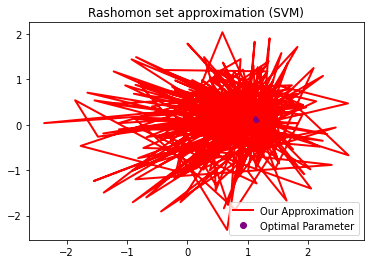

In [37]:
#plt.plot(extremes_l[:, 0], extremes_l[:, 1], 'o', color='black');
plt.plot(hull[:, 0], hull[:, 1], lw=2, color = 'red', label = 'Our Approximation')
plt.plot(center[0], center[ 1], 'o', color='purple', label = 'Optimal Parameter');
plt.plot([hull[0, 0], hull[-1, 0]], [hull[0, 1], hull[-1, 1]], lw=2, color = 'red')
plt.legend()
plt.title('Rashomon set approximation (SVM)');
plt.savefig('Rashomon_SVM_set.pdf')

## Getting mode predictor

In [38]:
def get_mode_prediction(models_in_ensemble, x):
    n_models = models_in_ensemble.shape[0]
    pred = np.zeros((n_models, x.shape[0]))
    for i in range(n_models):
        pred[i] = get_prediction(models_in_ensemble[i], x) 
        
    return st.mode(pred)[0] #np.mean(pred, axis = 0) 

In [39]:
get_mode_prediction(models_in_ensemble, X)

array([[-1., -1., -1., ..., -1., -1., -1.]])

In [115]:
montecarlo_tries = 10000
avg_ensamble_disagreement = 0
avg_optimal_disagreement = 0

n_range= np.array([15, 20, 50, 500, 1000])
n_size = len(n_range)
acc_ensembles = np.zeros((n_size, montecarlo_tries))
disagreements_difference = np.zeros((n_size, montecarlo_tries))
center_pred =  get_prediction(center, X)

for j in range(n_size):
    avg_ensamble_disagreement = 0
    avg_optimal_disagreement = 0
    
    models_in_ensemble = samp_in_hull_after(deln, vols, n_range[j])
    ensamble_predition = get_mode_prediction(models_in_ensemble, X)
    
    for i in tqdm(range(montecarlo_tries)):    
        random_model_pred = get_prediction(samp_in_hull_after(deln, vols, 1)[0], X)
        
#         avg_ensamble_disagreement += np.sum(ensamble_predition != random_model_pred)
#         avg_optimal_disagreement += np.sum( get_prediction(center, X) != random_model_pred)
    
        disagreements_difference[j, i] = np.sum(center_pred != random_model_pred) - np.sum(ensamble_predition != random_model_pred)
        acc_ensembles[j, i] = np.mean(ensamble_predition == Y_train)
        
#         disagreements_difference[j] = - avg_ensamble_disagreement/montecarlo_tries + avg_optimal_disagreement/montecarlo_tries
#         acc_ensembles[j] = np.mean(ensamble_predition == Y_train)


100%|█████████████████████████████████████| 10000/10000 [14:01<00:00, 11.88it/s]


In [116]:
np.mean(acc_ensembles, axis = 1), np.mean(disagreements_difference, axis = 1)

(array([0.75441157, 0.7600283 , 0.7571536 , 0.7598514 , 0.76055902]),
 array([274.6914, 310.47  , 304.1614, 343.7548, 269.9592]))

In [129]:
rng = np.random.default_rng()
res = st.bootstrap((disagreements_difference[3],), np.mean, confidence_level=0.95, random_state=rng)
res

BootstrapResult(confidence_interval=ConfidenceInterval(low=294.2581714030891, high=394.28267155455603), standard_error=25.696504430481983)

In [131]:
rng = np.random.default_rng()
res = st.bootstrap((acc_ensembles[3],), np.mean, confidence_level=0.95, random_state=rng, method = 'percentile')
res

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.7598513997611782, high=0.7598513997611782), standard_error=0.0)

In [130]:
343.7548 - 294.2581714030891, 394.28267155455603 - 343.7548

(49.49662859691091, 50.52787155455604)

In [88]:
b

(array([0.75918801, 0.75918801, 0.75918801, 0.75918801, 0.75918801,
        0.75918801, 0.75918801, 0.75918801, 0.75918801, 0.75918801]),)

In [24]:
dist = st.norm(loc=2, scale=4)  # our "unknown" distribution
data = dist.rvs(size=100, random_state=rng)

array([ 0.73806517,  2.45663895,  2.34394635,  5.33556337, -1.22642987,
       -0.98953971,  2.0517823 , -3.7555521 ,  6.39134995,  9.56367722,
        7.26099543, -2.29216057, -3.67918047,  3.44218649,  4.86743582,
        0.97751561,  4.38829687,  0.98093418, -3.4370054 , -0.93435419,
        9.47864557,  6.91637612, -0.21269389, -1.71186706,  4.21174654,
        7.2149373 ,  1.16574559,  2.5207006 , 10.02573911, -4.71668965,
        4.7996719 ,  7.11570189, -7.56959031, -5.27336176,  7.40275099,
       -2.80847786,  2.327643  , -3.89903404,  6.58463049, -1.53078982,
        4.44978653,  1.88280174,  2.22582935,  9.40396549,  2.56931928,
        0.02175121,  0.69695267,  2.49629881,  0.45145197,  3.20837338,
        5.8010331 , 10.2965826 ,  4.30024675, -0.496787  ,  0.85711741,
        5.88628032, -1.91142095,  3.72644342,  5.38293304, -1.52198422,
       -1.78905003,  0.77866129, -4.48791847,  5.13748639,  4.2036565 ,
       -3.40039175,  7.23066605,  3.63332122,  9.4461781 ,  1.97

In [ ]:
plt.plot(disagreements_difference[0], 'o')
plt.show()

array([[-2910., -2916.,  2910., ..., -2910., -2206., -2926.],
       [ 2687., -2407.,  2945., ...,  2655., -1577., -2659.],
       [ 2915.,  2897.,  2973., ..., -2729., -2971., -2223.],
       [-2951., -2789.,  -657., ..., -2951., -2879., -2943.]])